In [1]:
import numpy as np
from keras import models
from keras import layers
from keras.initializers import glorot_uniform
from utils import *

Using TensorFlow backend.


### 1、Identity Block
第 l 层卷积的输出越过两个隐层，直接到达第 l+3 层作为激活函数的输入
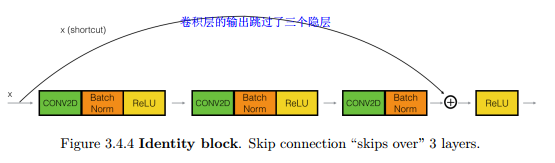

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    identity block 的实现代码
    
    Args:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: 整数类型，表示卷积核的尺寸
        filters: 包含整数元素的 list 类型数据，分别表示每一层卷积核的个数
        stage: 整数类型，用来对网络中的层进行命名
        block: string/character，used to name the layers, depending on their position in the network
    Returns:
        X: output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # define the name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # 分别获取三层卷积层中卷积核的数目
    F1, F2, F3 = filters
    # 保存输入的信息，因为在后面跳跃到的激活层中需要用到
    X_shortcut = X
    
    ########### Main Path ############
    # First component of main path
    # padding = 'valid' 表示不使用 padding
    X = layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1),
                     padding = 'valid', name = conv_name_base + '2a',
                     kernel_initializer = glorot_uniform(seed = 0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    # Second component of main path
    X = layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1),
                     padding = 'same', name = conv_name_base + '2b',
                     kernel_initializer = glorot_uniform(seed = 0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    
    # Third component of main path
    X = layers.Conv2D(filters = F3, kernel_size = (f, f), strides = (1, 1),
                     padding = 'same', name = conv_name_base + '2c',
                     kernel_initializer = glorot_uniform(seed = 0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X = layers.add([X, X_shortcut])      # 输入直接跳过隐层到达该位置
    X = layers.Activation('relu')(X)
    
    return X

### 2、Convolutional Block
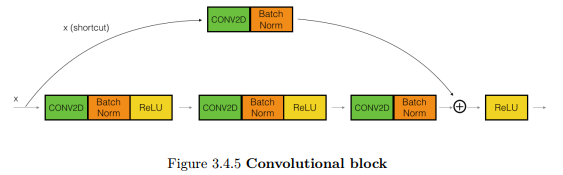

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    构建上图所示的 convolutional block
    
    Args:
        X: 输入数据
    """
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    
    # first component of main path
    X = layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (s, s), 
                     padding = 'valid', name = conv_name_base + '2a',
                     kernel_initializer = glorot_uniform(seed = 0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    # Second component of main path
    X = layers.Conv2D(filters  = F2, kernel_size = (f, f), strides = (1, 1),
                     padding = 'same', name = conv_name_base + '2b',
                     kernel_initializer = glorot_uniform(seed = 0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    
    # ShortCut Path
    X_shortcut = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (s, s), 
                              padding = 'valid', 
                              kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    # Third component of main path
    X = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1),
                     padding = 'valid', name = conv_name_base + '2c',
                     kernel_initializer = glorot_uniform(seed = 0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X = layers.add([X_shortcut, X])     # 有个限制条件是 X_shortcut 和 X 的维数必须是对齐的
    X = layers.Activation('relu')(X)
    
    return X

### 3、按照如下方式构建一个 ResNet 模型
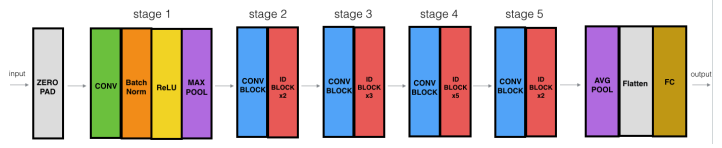

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    建立一个输入图片维数为 (64, 64, 3)， 输出类别数为 6 的 ResNet 模型，模型的层数为 50
    
    Args:
        input_shape: 输入图片的维数
        classes：模型输出的类别数
    Returns:
        model: models.Model() 对象
    """
    
    X_input = layers.Input(input_shape)            # 准备输入数据
    X = layers.ZeroPadding2D((3, 3))(X_input)      # 先对图片进行padding处理
    
    # stage 1
    X = layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), name = 'conv1',
                     kernel_initializer = glorot_uniform(seed = 0))(X)     # padding 默认使用的是 'valid'
    X = layers.BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPool2D((3, 3), strides = (2, 2))(X)
    
    # stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'b')
    X = identity_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'c')
    
    # stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'b')
    X = identity_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'c')
    X = identity_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'd')
    
    # stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'b')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'c')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'd')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'e')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'f')
    
    # stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'b')
    X = identity_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'c')
    
    # Average pool
    X = layers.AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    
    # output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation = 'softmax', name = 'fc' + str(classes), 
                    kernel_initializer = glorot_uniform(seed = 0))(X)
    
    # create model
    model = models.Model(inputs = X_input, outputs = X, name = 'ResNet50')
    
    return model

In [ ]:
model = ResNet50()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

In [ ]:
print('loading datasets...')
train_set_X, train_set_y, test_set_X, test_set_y = load_dataset()
train_set_y = convert_to_onehot(train_set_y, 6)
test_set_y = convert_to_onehot(test_set_y, 6)
print('finishing loading datasets.')
print('begin training...')
model.fit(train_set_X, train_set_y, epochs = 2, batch_size = 32, validation_data = (test_set_X, test_set_y))


loading datasets...
finishing loading datasets.
begin training...
Train on 1080 samples, validate on 120 samples
Epoch 1/2
